# Linear Regression (Error Estimates)
## Intuition
We know that our estimates aren't perfect, but we need to have a way to know how accurate or how inaccurate our predictions are.

We want to understand our error estimate for different parts of the regression:
1. Overall (how much of $\sigma^2_y$ be explained by our predicted values?)
2. $\beta$s individually (how well does each variable explain difference itself?)
3. $\beta$s collectively (do the features jointly have an impact?)

Let's split this into three parts, one for each section.

## Explanation
### R-Squared ($R^2$)
Let's start by understanding the sum of squared error. We need a baseline of variance, we call this the *total sum of squares*. This dispersion is analagous to the variance of y.

**Total Sum of Squares (TSS)**
$$
TSS = \sum_i (y_i - \bar{y})^2
$$

We want to have a measure of how much of this error is left over after using our regression estimates. We call this the *residual sum of squares*.

**Residual Sum of Squares (RSS)**
$$
RSS = \sum_i (y_i - \hat{y})^2 = \sum_i \epsilon_i^2
$$

\*Matrix form
$$
RSS = \epsilon^T\epsilon
$$

**R-Squared (Coefficient of Determination)**

This means, we can understand how much of the *variance* of $y$ can be explained by our estimates.

$$
R^2 = 1 - \frac{RSS}{TSS}
$$

#### Example
Let's generate the data and walk through the example

##### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

##### Data Recreation

In [2]:
np.random.seed(100)

# Generate X values
X1 = np.array(range(100))
X0 = np.ones(X1.shape)
X = np.vstack([X0, X1]).T

# True beta values
true_betas = [3, 0.5]

# Estimate Y
y = X @ true_betas + np.random.randn(100) * 4

# estimate Y
betas = np.linalg.inv(X.T @ X) @ X.T @ y
yhat = X @ betas

##### TSS

In [3]:
# Total sum of squares
ybar = np.mean(y)
ydist = y - ybar
tss = ydist.T @ ydist
print(f"TSS:\t{round(tss, 4)}")

TSS:	21542.2313


##### RSS

In [4]:
# calculate residuals
residuals = y - yhat
rss = residuals.T @ residuals
print(f"RSS:\t{round(rss, 4)}")

RSS:	1497.1118


Now, we can see that our $RSS$ is much lower than the $TSS$. This means that there is a small share of error left after subtracting our $\hat{y}$.

In [5]:
# R^2
rsquared = 1 - rss / tss
print(f"R-squared:\t{round(rsquared, 4)}")

R-squared:	0.9305


### $\beta$ Variance & Standard Error
#### Variance
Now that we know our estimates of $\beta$ from the last notebook, we can now understand the variance of $\hat{\beta}$. First, let's put $\beta$ in terms of it's true form and residual $\epsilon$.

We can rewrite $\beta$ as

$$
\begin{aligned}
    \hat{\beta}
        &= (X^TX)^{-1}X^Ty \\
        &= (X^TX)^{-1}X^Ty \\
        &= (X^TX)^{-1}X^T(X\beta + \epsilon)\\
        &= \beta + (X^TX)^{-1}X^T\epsilon
\end{aligned}
$$

This means it's unbiased if we take the expectation of $\beta$, so long as there is no correlation of $X^T$ and $\epsilon$ and that $\epsilon$ is centered around 0.

$$
\begin{aligned}
    E(\hat{\beta})
        &= \beta + (X^TX)^{-1}X^TE(\epsilon) \\
        &= \beta
\end{aligned}
$$

Using these properties and the identities from the equation above, we can now make an estimate of the variance-covariance matrix by taking the varinace of our matrix.

First, using the equation above, we know:
$$
\hat{\beta} - \beta = (X^TX)^{-1}X^T\epsilon
$$

Now we can use this to find the variance-covariance matrix of our $\beta$ estimates:

$$
\begin{aligned}
    Var(\hat{\beta})
        &= E[(X^TX)^{-1}X^T\epsilon[(X^TX)^{-1}X^T\epsilon]^T] \\
        &= E[(X^TX)^{-1}X^T\epsilon^{} \epsilon^T X(X^TX)^{-1}] \\
\end{aligned}
$$

And assuming error terms are uncorrelated

$$
\begin{aligned}
    Var(\hat{\beta})
        &= E[(X^TX)^{-1}X^T \sigma^2 I X(X^TX)^{-1}] \\
        &= \sigma^2(X^TX)^{-1}\
\end{aligned}
$$

Meaning our $\beta$ estimated variances for each variable are:

$$
    diag\left(\sigma^2(X^TX)^{-1}\right)
$$

In this case, our estimate of $\sigma^2$ is made by calculating the amount of unexplained variance (which we assume is uncorrelated with our $\beta$ terms), we can do this by taking the variance of our residuals. Because the sum of residuals will equal 0 (due to the fact that we minimized residual error), we can make our estimate as follows

$$
\textrm{VCV}_\beta = RSS(X^TX)^{-1}
$$

#### Standard Error

$$
\textrm{SE}_\beta = diag \left( \frac{RSS}{(n-k-1)}(X^TX)^{-1} \right) ^ {0.5}
$$


In [6]:
se_beta = (rss / (X.shape[0] - X.shape[1]) * np.linalg.inv(X.T @ X).diagonal()) ** .5

for i, se in enumerate(se_beta):
    print(f"Standard Error Beta{i}:\t{round(se, 4)}")

Standard Error Beta0:	0.7759
Standard Error Beta1:	0.0135


Let's look at a quick summary table of the info we've gathered

In [7]:
print("Variable Results\n")
print("Var\tCoef\tSE\tt")
print("-" * 30)

for x in range(len(betas)):
    print(f"Beta{x}:\t{round(betas[x], 4)}\t{round(se_beta[x], 4)}\t{round(betas[x] / se_beta[x], 4)}")

print("\nModel Results")
print("-" * 30, sep="")
print(f"R-squared:\t{round(1 - rss / tss, 4)}")

Variable Results

Var	Coef	SE	t
------------------------------
Beta0:	3.0548	0.7759	3.9372
Beta1:	0.4905	0.0135	36.2235

Model Results
------------------------------
R-squared:	0.9305


### $\beta$ Overall Significance
#### Joint Hypothesis tests
Sometimes, regression coefficients may be collinear, which means we can't tell apart coefficients. We can conduct an F-test which essentially tries to find the relative amount of error reduced by having multiple variables.

There are some situations where this applies
1. $H_0: \beta_1=0$
2. $H_0: \beta_1=\alpha$
3. $H_0: \beta_1=\beta_2$
4. $H_0: \beta_1 + \beta_2 = 1$
5. $H_0: (\beta_1=0) \cap (\beta_2=0) $

Conceptually, we can think of the F-Test as the amount of residuals reduced by variable divided by the amount of residuals.

##### Unrestricted
$$
Y=\beta_0 + \beta_1X_1 + \beta_2X_2 + \dots + \epsilon
$$

##### Restricted
$$
Y = \beta_0 + \beta_2X_2 + \dots + \beta_{k-q}X_{k-q}+\epsilon
$$

##### F-test Procedure
$$
F = \frac{\frac{{RSS}_R - {RSS}_{UR}}{q}}{\frac{{RSS}_{UR}}{n-(k+1)}}
$$

Where $q$ is the number of restrictions, and $k+1$ are the number of variables in the unrestricted regression

It actually makes intutive sense. One way of rewriting the F-test would be

##### Example
Let's use the same data we did for the first example

In [10]:
# run regression
X_r = X.T[0].reshape(-1,1)
B_r = np.linalg.inv(X_r.T @ X_r) @ (X_r.T @ y)
res_r = X_r @ B_r - y
rss_r = res_r @ res_r

# gather additional f-test results
q = X.shape[1] - X_r.shape[1]
k = X.shape[1] -1
n = len(X)

F = ((rss_r - rss) / q) / (rss / (n - (k + 1)))

print(f"F-Statistic: {round(F, 4)}")

F-Statistic: 1312.141


We can compare this to our critical value of F, which is calculated as follows in python

In [11]:
import scipy.stats
f_crit = scipy.stats.f.ppf(q=1-0.05, dfn=q, dfd=(n - (k + 1)))

print(f"Critical F-Value: {round(f_crit, 4)}")

Critical F-Value: 3.9381


#### Summary

And let's now look at our model's summary statistics

In [12]:
print("Variable Results\n")
print("Var\tCoef\tSE\tt")
print("-" * 30)

for x in range(len(betas)):
    print(f"Beta{x}:\t{round(betas[x], 4)}\t{round(se_beta[x], 4)}\t{round(betas[x] / se_beta[x], 4)}")

print("\nModel Results")
print("-" * 30, sep="")
print(f"R-squared:\t{round(1 - rss / tss, 4)}")
print(f"F-Statistic:\t{round(F, 4)}")

Variable Results

Var	Coef	SE	t
------------------------------
Beta0:	3.0548	0.7759	3.9372
Beta1:	0.4905	0.0135	36.2235

Model Results
------------------------------
R-squared:	0.9305
F-Statistic:	1312.141


In [13]:
import statsmodels.api as sm

print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1312.
Date:                Tue, 05 May 2020   Prob (F-statistic):           1.50e-58
Time:                        00:00:38   Log-Likelihood:                -277.20
No. Observations:                 100   AIC:                             558.4
Df Residuals:                      98   BIC:                             563.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0548      0.776      3.937      0.0

As we can see, we are able to verify our figures in the `statsmodels` OLS package.

### $\beta$ Example with multiple covariates
#### Example
Let's first add a new $x$ variable which is going to be a function of $X1$, but also has explanatory power.

In [14]:
np.random.seed(200)

X2 = -12 * X1 ** .97 + np.random.rand(n) * 2
X_new = np.array([np.ones(X1.shape), X1, X2]).T
true_betas_new = [3, 0.5, 0.07]
y_new = X_new @ true_betas_new + np.random.randn(n) * 4

Let's look at pairplots of these variables

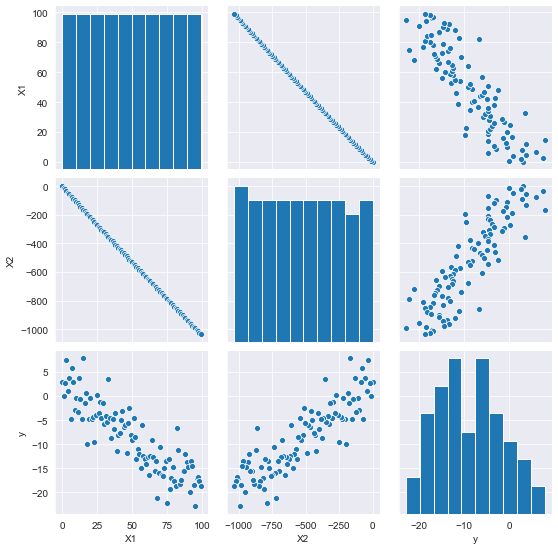

In [15]:
df = pd.DataFrame(X_new, columns=['const', 'X1', 'X2']).assign(y=y_new)

sns.pairplot(df[['X1', 'X2', 'y']])
plt.show()

Now, if we get our beta estimates, standard error, and p-values, we can see that our estimates are incorrect.

In [16]:
# Regression Predictions
betas_unrestricted = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y_new
yhats_unrestricted = X_new @ betas_unrestricted
resid_unrestricted = y_new - yhats_unrestricted
error_unrestricted = (resid_unrestricted @ resid_unrestricted / (X_new.shape[0] - X_new.shape[1]) *
                      np.linalg.inv(X_new.T @ X_new).diagonal()) ** .5

# P-Values
pvalues = betas_unrestricted / error_unrestricted

unrestricted_rss = resid_unrestricted @ resid_unrestricted
tss = (y_new - np.mean(y_new)) @ (y_new - np.mean(y_new))

In this case, both our explanatory $x$ variables are insignificant, but our $R$-squared is high. This suggests our specified model has some sort of explanatory power. We can test for joint significance to find the answer.

We can start by running our restricted regression & finding our F-statistic.

In [17]:
# Restricted Variables
X_r = X_new.T[0].reshape(-1,1)
betas_restricted = np.linalg.inv(X_r.T @ X_r) @ X_r.T @ y_new
yhats_restricted = X_r @ betas_restricted
resid_restricted = y_new - yhats_restricted
restricted_rss = resid_restricted @ resid_restricted

q = 2
f_test = ((restricted_rss - unrestricted_rss) / q) / (unrestricted_rss / (n - q - 1))

Now, let's look at our results

In [18]:
# Summary
print("Variable Results")
print()
print("Var\tCoef\tT-Stat")
print("-" * 25)

for x in range(3):
    print(f"Beta{x}:\t{round(betas_unrestricted[x], 4)}\t{round(pvalues[x], 4)}")

print("\nSignificance")
print("-" * 25, sep="")
print(f"R-squared:\t{round(1 - unrestricted_rss / tss, 4)}")
print(f"F-statistic:\t{round(f_test, 4)}")

Variable Results

Var	Coef	T-Stat
-------------------------
Beta0:	3.3436	2.7131
Beta1:	1.1375	0.9929
Beta2:	0.1304	1.1845

Significance
-------------------------
R-squared:	0.7728
F-statistic:	164.9924


## Comparision
Let's compare this to the output from statsmodels.

In [19]:
import statsmodels.api as sm

reg = sm.OLS(y_new, X_new).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     165.0
Date:                Tue, 05 May 2020   Prob (F-statistic):           6.07e-32
Time:                        00:00:48   Log-Likelihood:                -265.46
No. Observations:                 100   AIC:                             536.9
Df Residuals:                      97   BIC:                             544.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3436      1.232      2.713      0.0